# Heads Up

In this notebook, we start generating random undirected weighted
graphs to not only better approximate real world road network but
also facilitate the feature engineering of nodes and edges

# Some Take-Aways

Beam search combined with some centrality heuristics
seem to approximate real world application better.

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import plot_g

In [11]:
NUM_NODE = 100
WEIGHT_MIN = .0
WEIGHT_MAX = 1.

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-12 15:03:37.419311. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [12]:
def generate_low_degree_g(node_size=20, min_out_degree=2, max_out_degree=4, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):
    
    G = nx.Graph()
    G.add_nodes_from(range(0, node_size))
    
    for node in G.nodes:
        
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        random.shuffle(tmp_nodes)
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for tmp_node in tmp_nodes:

            if G.degree(tmp_node) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                # This node has maximum number of neighbors already
                continue
            
            weight = random.uniform(weight_min, weight_max)
            G.add_edge(node, tmp_node, weight=weight)
        
    return G

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-12 15:03:41.511813. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-12 15:03:44.446918. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


4
2
20
36


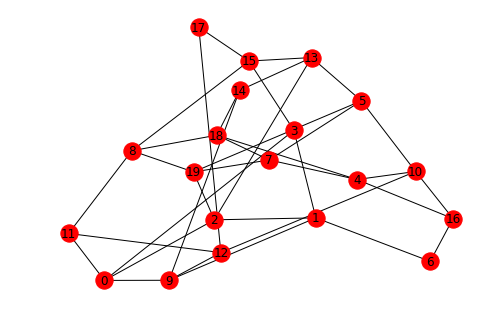

In [13]:
G = generate_low_degree_g()
max_degree = max(G.degree, key=lambda d: d[1])[1]
min_degree = min(G.degree, key=lambda d: d[1])[1]
print(max_degree)
print(min_degree)
print(G.number_of_nodes())
print(G.number_of_edges())
plot_g(G)

In [ ]:
def traverse_g_helper(layer_2_layer_dict, G, parent_node, cur_node, step, depth):
    
    if step > depth:
        return
    
    layer_2_layer_dict[step-1][(parent_node, cur_node)] = \
                        filter(lambda edge: edge[1] != parent_node, G.edges(cur_node))
        
    for edge in G.edges(cur_node):
        
        neighbor = edge[1]
        if neighbor == parent_node:
            continue
        
#         print('Step %d: from %d to %d' % (step, cur_node, neighbor))
        traverse_g_helper(layer_2_layer_dict, G, cur_node, neighbor, step+1, depth)
    
def traverse_g(G, src, parent_node=-1, depth=3):
    
    layer_2_layer_dict = [dict() for _ in range(depth)]
    traverse_g_helper(layer_2_layer_dict, G, parent_node, src, 1, depth)
    
    return layer_2_layer_dict

In [ ]:
DST_NEIGHBOR_LAYERS = generate_dst_neighbor_layers(G)
PAIR_NEIGHBOR_LAYERS = generate_pair_neighbor_layers(G)

In [ ]:
DST_NEIGHBOR_LAYERS[0]

In [ ]:
def encode_layers(G, layers, end=None, depth=3):
    
    assert type(layers) is list and len(layers) == depth
    ret = [ np.ones(max_out_degree ** (i+1)) for i in range(depth)]
    label = None
    
    for layer in range(depth):
        
        assert type(layers[layer]) is dict
        
        cnt = 0
        
        for _, edge_list in layers[layer].items():
            
            assert type(edge_list) is list
            
            for idx, edge in enumerate(edge_list):
                ret[layer][cnt] = G.get_edge_data(edge[0], edge[1])['weight']
                cnt += 1
                
                if layer == 0 and end is not None:
                    if end == edge[1]:
                        label = idx
        
    return reduce(lambda x, y: np.hstack([x, y]), ret), label

def encode_sample(G, start, end, dst, depth=3):
    
    dst_layers_encoded, _ = encode_layers(G, DST_NEIGHBOR_LAYERS[dst])
    edge_layers_encoded, label = encode_layers(G, DST_NEIGHBOR_LAYERS[start], end=end)
    
    return np.hstack([edge_layers_encoded, dst_layers_encoded]), label

X = []
y = []

for paths in nx.all_pairs_dijkstra_path(G):
    print("src :%d" % paths[0])
    print(paths[1])
    print('')
    src = paths[0]
    for dst, path in paths[1].items():
        
        if dst == src:
            continue
            
        # X = cur_node + dst_node
        # y = next_node (Dijkstra)
        
        cur_node = src
        for mid_node in path[1:]:
            
            print('X:(%d, %d), y:(%d)' % (cur_node, dst, mid_node))
            feature, label = encode_sample(G, cur_node, mid_node, dst)
            X.append(feature)
            y.append(label)
            
            cur_node = mid_node
            
            # Retrieve edge(cur_node, mid_node) || dst
            
#         print(cur_node, dst)
        print(path)
        print('')

In [ ]:
print(y[2])
DST_NEIGHBOR_LAYERS[3]

In [ ]:
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)
y.tolist().count(3)

In [ ]:
def generate_dst_neighbor_layers(G, depth=3):
    
    ret = dict()
    for node in G.nodes:
        ret[node] = traverse_g(G, node, parent_node=-1, depth=depth)
    
    return ret

def generate_pair_neighbor_layers(G, depth=3):
    
    ret = dict()
    for edge in G.edges:
        ret[(edge[0], edge[1])] = traverse_g(G, edge[1], parent_node=edge[0], depth=depth)
        ret[(edge[1], edge[0])] = traverse_g(G, edge[0], parent_node=edge[1], depth=depth)
    
    return ret

def generate_dataset(G, depth=3):
    
    pass

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-12 15:51:43.115719. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


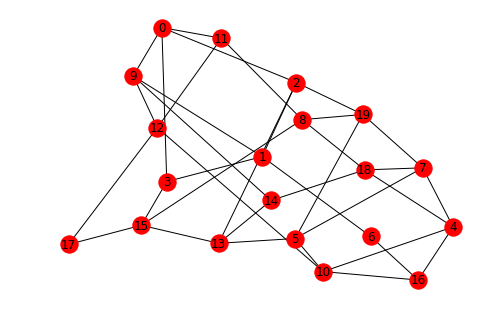

In [41]:
plot_g(G)

In [135]:
src, dst = 17, 17

def extract_path(prev, src, dst):
    
    path = []
    u = dst

    while prev[u] != src:
        path.insert(0, u)
        u = prev[u]
    
    path.insert(0, u)
    path.insert(0, src)
    return path

def bfs_beam_edges_path(G, src, dst):
    
    centrality = nx.edge_betweenness_centrality(G, weight='weight', \
                                              k=G.number_of_nodes(), \
                                            normalized=True)
    
    prev = [-1 for _ in range(G.number_of_nodes())]
    
    for u, v in nx.bfs_beam_edges(G, src, value=centrality.get):
        prev[v] = u

    return extract_path(prev, src, dst)

for src in G.nodes():
    for dst in G.nodes():
        
        if src == dst:
            continue
        
        
        print(nx.dijkstra_path(G, src, dst, weight='weight'))
        print(bfs_beam_edges_path(G, src, dst))
        print('')

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-13 10:47:32.419621. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


[0, 3, 1]
[0, 3, 1]

[0, 2]
[0, 2]

[0, 3]
[0, 3]

[0, 11, 12, 10, 4]
[0, 9, 12, 10, 4]

[0, 2, 13, 5]
[0, 2, 19, 5]

[0, 3, 1, 6]
[0, 3, 1, 6]

[0, 2, 13, 5, 7]
[0, 2, 19, 7]

[0, 11, 8]
[0, 11, 8]

[0, 3, 1, 9]
[0, 9]

[0, 11, 12, 10]
[0, 9, 12, 10]

[0, 11]
[0, 11]

[0, 11, 12]
[0, 9, 12]

[0, 2, 13]
[0, 2, 13]

[0, 3, 1, 9, 14]
[0, 9, 14]

[0, 3, 15]
[0, 3, 15]

[0, 11, 12, 10, 16]
[0, 3, 1, 6, 16]

[0, 11, 12, 17]
[0, 3, 15, 17]

[0, 11, 12, 10, 4, 18]
[0, 9, 14, 18]

[0, 2, 19]
[0, 2, 19]

[1, 3, 0]
[1, 9, 0]

[1, 2]
[1, 2]

[1, 3]
[1, 3]

[1, 9, 14, 18, 4]
[1, 6, 16, 4]

[1, 9, 12, 10, 5]
[1, 2, 19, 5]

[1, 6]
[1, 6]

[1, 9, 14, 18, 7]
[1, 2, 19, 7]

[1, 9, 12, 11, 8]
[1, 2, 19, 8]

[1, 9]
[1, 9]

[1, 9, 12, 10]
[1, 9, 12, 10]

[1, 9, 12, 11]
[1, 9, 0, 11]

[1, 9, 12]
[1, 9, 12]

[1, 2, 13]
[1, 2, 13]

[1, 9, 14]
[1, 9, 14]

[1, 2, 13, 15]
[1, 3, 15]

[1, 6, 16]
[1, 6, 16]

[1, 9, 12, 17]
[1, 9, 12, 17]

[1, 9, 14, 18]
[1, 9, 14, 18]

[1, 2, 19]
[1, 2, 19]

[2, 0]
[2, 0]

[2, 1]

In [136]:
edge_centrality = nx.edge_betweenness_centrality(G, k=G.number_of_nodes(), weight='weight')

for edge, centrality in edge_centrality.items():
    print(edge, centrality, G.get_edge_data(edge[0], edge[1])['weight'])

((1, 6), 0.08421052631578947, 0.40800218655862286)
((0, 3), 0.09999999999999999, 0.025814955733833633)
((1, 2), 0.05789473684210526, 0.5701525286149624)
((2, 19), 0.02631578947368421, 0.8310080777506278)
((4, 16), 0.0, 0.5130471060410248)
((14, 18), 0.08947368421052632, 0.5745373583335684)
((2, 13), 0.11578947368421053, 0.014128001399186019)
((7, 19), 0.0, 0.606150605861962)
((0, 11), 0.15263157894736842, 0.4743024951233651)
((12, 17), 0.09999999999999999, 0.046489986849825526)
((4, 18), 0.08421052631578947, 0.28679810790546956)
((1, 3), 0.042105263157894736, 0.620823682253037)
((3, 15), 0.010526315789473684, 0.82215315177847)
((8, 15), 0.07368421052631578, 0.13957028705475227)
((4, 10), 0.1368421052631579, 0.10273955057253292)
((9, 14), 0.09473684210526316, 0.061054570227627725)
((8, 11), 0.09999999999999999, 0.30233025528780033)
((13, 15), 0.02631578947368421, 0.8001196566967258)
((4, 7), 0.005263157894736842, 0.4992577732680854)
((5, 13), 0.042105263157894736, 0.8484126435935295)
((

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-13 10:48:01.295299. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


In [137]:
edge_centrality

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-13 10:48:11.153727. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


{(0, 2): 0.12105263157894737,
 (0, 3): 0.09999999999999999,
 (0, 9): 0.0,
 (0, 11): 0.15263157894736842,
 (1, 2): 0.05789473684210526,
 (1, 3): 0.042105263157894736,
 (1, 6): 0.08421052631578947,
 (1, 9): 0.14736842105263157,
 (2, 13): 0.11578947368421053,
 (2, 19): 0.02631578947368421,
 (3, 15): 0.010526315789473684,
 (4, 7): 0.005263157894736842,
 (4, 10): 0.1368421052631579,
 (4, 16): 0.0,
 (4, 18): 0.08421052631578947,
 (5, 7): 0.07368421052631578,
 (5, 10): 0.14210526315789473,
 (5, 13): 0.042105263157894736,
 (5, 19): 0.08421052631578947,
 (6, 16): 0.04736842105263158,
 (7, 18): 0.021052631578947368,
 (7, 19): 0.0,
 (8, 11): 0.09999999999999999,
 (8, 15): 0.07368421052631578,
 (8, 18): 0.021052631578947368,
 (8, 19): 0.031578947368421054,
 (9, 12): 0.11052631578947368,
 (9, 14): 0.09473684210526316,
 (10, 12): 0.24210526315789474,
 (10, 16): 0.10526315789473684,
 (11, 12): 0.25789473684210523,
 (12, 17): 0.09999999999999999,
 (13, 14): 0.010526315789473684,
 (13, 15): 0.026315789